# Data

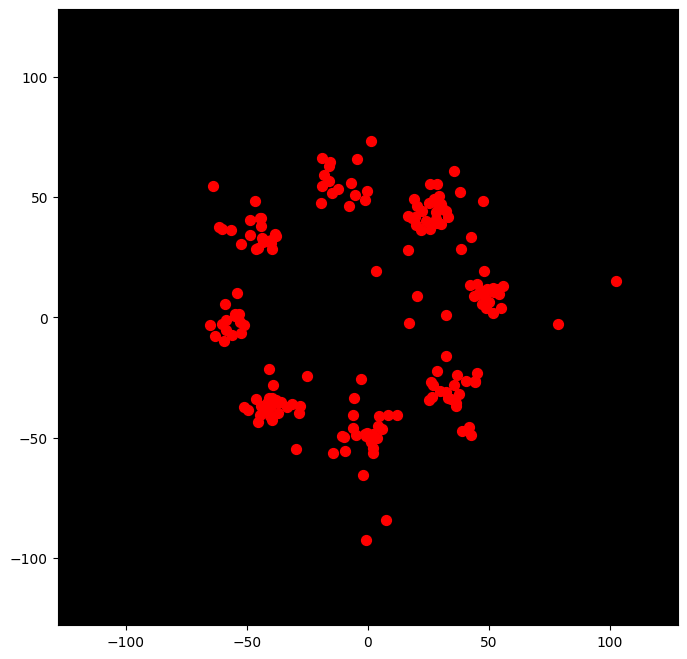

In [43]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import random


import torch

def rotate_point_cloud(points):
    """
    Randomly rotates the point cloud around the Z-axis for 2D, or around a random axis for 3D.

    Args:
        points (torch.Tensor): Input point cloud of shape (N, 2) or (N, 3).

    Returns:
        torch.Tensor: Rotated point cloud of shape (N, 2) or (N, 3).
    """
    if points.shape[1] == 2:
        angle = torch.rand(1).item() * 2 * torch.pi
        angle = torch.tensor(angle)
        rotation_matrix = torch.tensor([
            [torch.cos(angle), -torch.sin(angle)],
            [torch.sin(angle), torch.cos(angle)]
        ])
        return points @ rotation_matrix.T
    elif points.shape[1] == 3:
        # Rotation around a random axis in 3D
        angle = torch.rand(1).item() * 2 * torch.pi
        angle = torch.tensor(angle)
        axis = torch.rand(3) - 0.5
        axis = axis / axis.norm()
        rotation_matrix = torch.eye(3)
        rotation_matrix = rotation_matrix + torch.sin(angle) * torch.cross(torch.eye(3), axis) + (1 - torch.cos(angle)) * (axis.unsqueeze(1) @ axis.unsqueeze(0))
        return points @ rotation_matrix.T
    else:
        raise ValueError("Points should have shape (N, 2) or (N, 3)")

def translate_point_cloud(points):
    """
    Randomly translates the point cloud.

    Args:
        points (torch.Tensor): Input point cloud of shape (N, 2) or (N, 3).

    Returns:
        torch.Tensor: Translated point cloud of shape (N, 2) or (N, 3).
    """
    translation = torch.rand(1, points.shape[1]) - 0.5
    return points + translation



def pad_point_cloud(point_cloud, uncertainty, max_points):
    """
    Pads the point cloud to a fixed number of points.

    Args:
        point_cloud (torch.Tensor): Input point cloud of shape (N, 2).
        uncertainty (torch.Tensor): Uncertainty values of shape (N,).
        max_points (int): Number of points to pad to.

    Returns:
        tuple: Padded point cloud of shape (max_points, 2), padded uncertainty, and the number of original points.
    """
    num_points = point_cloud.shape[0]
    if num_points < max_points:
        padded_points = torch.zeros((max_points, point_cloud.shape[1]), dtype=torch.float32)
        padded_uncertainty = torch.zeros(max_points, dtype=torch.float32)
        padded_points[:num_points, :] = point_cloud
        padded_uncertainty[:num_points] = uncertainty
    else:
        padded_points = point_cloud[:max_points, :]
        padded_uncertainty = uncertainty[:max_points]
    return padded_points, padded_uncertainty, num_points

class PointCloudDataset(Dataset):
    """
    Point Cloud Dataset.

    Args:
        csv_dir (str): Directory containing CSV files.
        num_files (int): Number of CSV files.
        max_points (int): Maximum number of points in the point cloud.
        augment (bool): Whether to apply data augmentation.
    """

    def __init__(self, csv_dir, num_files, max_points, augment=False):
        self.csv_dir = csv_dir
        self.num_files = num_files
        self.max_points = max_points
        self.augment = augment

    def __len__(self):
        return self.num_files

    def __getitem__(self, idx):
        file_path = os.path.join(self.csv_dir, f"{idx + 1}.csv")
        data = pd.read_csv(file_path)

        # Extract x, y coordinates and uncertainty
        x = torch.tensor(data.iloc[:, 0].values, dtype=torch.float32)
        y = torch.tensor(data.iloc[:, 1].values, dtype=torch.float32)
        uncertainty = torch.tensor(data.iloc[:, 2].values, dtype=torch.float32)
        points = torch.stack((x, y), dim=1)

        if self.augment:
            points = rotate_point_cloud(points)
            points = translate_point_cloud(points)

        # Pad point cloud and uncertainty
        padded_points, padded_uncertainty, num_points = pad_point_cloud(points, uncertainty, self.max_points)

        # Extract label (fourth column)
        label = torch.tensor(data.iloc[0, 3], dtype=torch.float32)

        # Create mask
        mask = torch.tensor([1] * num_points + [0] * (self.max_points - num_points), dtype=torch.float32)

        return padded_points, padded_uncertainty, label, mask



def collate_fn(batch):
    """
    Custom collate function for DataLoader.

    Args:
        batch (list): List of samples.

    Returns:
        tuple: Batch of points, uncertainties, labels, and masks.
    """
    points = torch.stack([item[0] for item in batch])
    uncertainties = torch.stack([item[1] for item in batch])
    labels = torch.stack([item[2] for item in batch])
    masks = torch.stack([item[3] for item in batch])
    return points, uncertainties, labels, masks


def create_dataloader(csv_dir, num_files, max_points, batch_size, augment=False):
    """
    Creates a DataLoader for the Point Cloud Dataset.

    Args:
        csv_dir (str): Directory containing CSV files.
        num_files (int): Number of CSV files.
        max_points (int): Maximum number of points in the point cloud.
        batch_size (int): Batch size.
        augment (bool): Whether to apply data augmentation.

    Returns:
        DataLoader: DataLoader for the dataset.
    """
    dataset = PointCloudDataset(csv_dir, num_files, max_points, augment=augment)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    return dataloader


# Example usage
csv_dir = 'datapointvae/'
num_files = 6000
max_points = 1024
batch_size = 32
augment = True  # Enable data augmentation

dataloader = create_dataloader(csv_dir, num_files, max_points, batch_size, augment=augment)

# Fetch a batch of data
points, labels, uncertainties, masks = next(iter(dataloader))

# Visualize a data point
import matplotlib.pyplot as plt


def visualize_point_cloud(points, mask):
    """
    Visualizes a point cloud with a black background and red points.
    
    Args:
        points (torch.Tensor): Point cloud of shape (N, 2).
        mask (torch.Tensor): Mask indicating valid points.
    """
    # Filter out padding points
    filtered_points = points[mask]
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, facecolor='black')
    ax.set_xlim(-128, 128)
    ax.set_ylim(-128, 128)
    # background color black
    ax.set_facecolor('black')
    ax.scatter(filtered_points[:, 0], filtered_points[:, 1], s=50, c='red', marker='o')

# Fetch a batch of data from the DataLoader
points, labels,uncertainties, masks = next(iter(dataloader))

# Select a data point for visualization
data_point = points[0].numpy()
mask = masks[0].numpy().astype(bool)

# Visualize the point cloud
visualize_point_cloud(data_point, mask)



# Models

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch3d.loss import chamfer_distance

class TNet(nn.Module):
    """
    T-Net module for learning a transformation matrix to align input point clouds.
    
    Args:
        k (int): The dimension of the input point cloud.
    """
    def __init__(self, k):
        super(TNet, self).__init__()
        self.k = k
        self.conv1 = nn.Conv1d(k, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k * k)
        self.iden = torch.eye(k).flatten().unsqueeze(0)

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        iden = self.iden.repeat(batchsize, 1).to(x.device)
        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x

class PointNetEncoder(nn.Module):
    """
    PointNet encoder for encoding point clouds into a latent space representation.
    
    Args:
        latent_dim (int): The dimension of the latent space.
        input_dim (int): The dimension of the input point cloud.
        use_tnet (bool): Whether to use the T-Net module.
    """
    def __init__(self, latent_dim, input_dim=3, use_tnet=True):
        super(PointNetEncoder, self).__init__()
        self.use_tnet = use_tnet
        self.input_dim = input_dim
        if self.use_tnet:
            self.tnet = TNet(k=input_dim)
        self.conv1 = nn.Conv1d(input_dim, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3_mean = nn.Linear(256, latent_dim)
        self.fc3_logvar = nn.Linear(256, latent_dim)

    def forward(self, x, mask):
        if self.use_tnet:
            trans = self.tnet(x)
            x = torch.bmm(trans, x)

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = x * mask.float()

        x = torch.max(x, 2)[0]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc3_mean(x)
        logvar = self.fc3_logvar(x)
        return mean, logvar

class PointNetDecoder(nn.Module):
    """
    PointNet decoder for reconstructing point clouds from the latent space representation.
    
    Args:
        latent_dim (int): The dimension of the latent space.
        num_points (int): The number of points in the output point cloud.
        output_dim (int): The dimension of the output point cloud.
    """
    def __init__(self, latent_dim, num_points, output_dim=3):
        super(PointNetDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, num_points * output_dim)
        self.num_points = num_points
        self.output_dim = output_dim

    def forward(self, z, mask):
        x = F.relu(self.fc1(z))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = x.view(-1, self.output_dim, self.num_points)
        x = x * mask.unsqueeze(1).float()
        return x

class PointNetVAE(nn.Module):
    """
    PointNet Variational Autoencoder for point clouds.
    
    Args:
        latent_dim (int): The dimension of the latent space.
        num_points (int): The number of points in the output point cloud.
        input_dim (int): The dimension of the input point cloud.
        output_dim (int): The dimension of the output point cloud.
        use_tnet (bool): Whether to use the T-Net module.
    """
    def __init__(self, latent_dim, num_points, input_dim=3, output_dim=3, use_tnet=True):
        super(PointNetVAE, self).__init__()
        self.encoder = PointNetEncoder(latent_dim, input_dim, use_tnet)
        self.decoder = PointNetDecoder(latent_dim, num_points, output_dim)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x, mask):
        mean, logvar = self.encoder(x, mask)
        z = self.reparameterize(mean, logvar)
        recon_x = self.decoder(z, mask)
        return recon_x, mean, logvar

def loss_function(recon_x, x, mean, logvar, mask, loss_type='mse'):
    """
    Loss function for the VAE, including reconstruction loss and KL divergence.
    
    Args:
        recon_x (torch.Tensor): Reconstructed point cloud.
        x (torch.Tensor): Original point cloud.
        mean (torch.Tensor): Mean of the latent space distribution.
        logvar (torch.Tensor): Log variance of the latent space distribution.
        mask (torch.Tensor): Mask indicating valid points.
        loss_type (str): Type of reconstruction loss ('mse', 'chamfer', 'emd').

    Returns:
        tuple: Reconstruction loss and KL divergence.
    """
    recon_x = recon_x.permute(0, 2, 1)
    x = x.permute(0, 2, 1)
    mask = mask.unsqueeze(2).float()
    
    if loss_type == 'mse':
        recon_loss = F.mse_loss(recon_x * mask, x * mask, reduction='sum')
    elif loss_type == 'chamfer':
        recon_loss = chamfer_distance(recon_x * mask, x * mask)[0]
    elif loss_type == 'emd':
        # Note: PyTorch3D does not have a direct EMD implementation, consider implementing your own or using an available library.
        raise NotImplementedError("EMD loss is not implemented.")
    else:
        raise ValueError(f"Unsupported loss type: {loss_type}")

    kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return recon_loss, kld_loss



In [57]:
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Subset
import numpy as np

class Trainer:
    """
    Trainer class for training and validating the PointNetVAE model.
    
    Args:
        model (nn.Module): The PointNetVAE model.
        train_loader (DataLoader): DataLoader for the training data.
        val_loader (DataLoader): DataLoader for the validation data.
        optimizer (torch.optim.Optimizer): Optimizer for the model.
        criterion (function): Loss function for the model.
        device (str): Device to run the model on ('cpu' or 'cuda').
        log_dir (str): Directory to save TensorBoard logs.
    """
    def __init__(self, model, train_loader, val_loader, optimizer, criterion, device='cuda', log_dir='./logs'):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.writer = SummaryWriter(log_dir)
        self.model.to(self.device)
        self.step = 0
    def train(self, epochs):
        """
        Trains the model for a given number of epochs.

        Args:
            epochs (int): Number of epochs to train the model for.
        """
        for epoch in range(epochs):
            self.model.train()
            train_recon_loss = 0
            train_kld_loss = 0
            
            for batch in self.train_loader:
                self.step += 1
                points, uncertainties, labels, masks = batch
                points, masks = points.to(self.device), masks.to(self.device)

                self.optimizer.zero_grad()
                recon_points, mean, logvar = self.model(points,masks)
                recon_loss, kld_loss = self.criterion(recon_points, points, mean, logvar, masks)
                loss = recon_loss + kld_loss
                # step logging
                self.writer.add_scalar('Loss/recon_loss_step', recon_loss.item(), self.step)
                self.writer.add_scalar('Loss/kld_loss_step', kld_loss.item(), self.step)
                self.writer.add_scalar('Loss/total_loss_step', loss.item(), self.step)
                

                loss.backward()
                self.optimizer.step()

                train_recon_loss += recon_loss.item()
                train_kld_loss += kld_loss.item()

            train_recon_loss /= len(self.train_loader)
            train_kld_loss /= len(self.train_loader)
            self.writer.add_scalar('Loss/train_recon', train_recon_loss, epoch)
            self.writer.add_scalar('Loss/train_kld', train_kld_loss, epoch)
            self.writer.add_scalar('Loss/total_loss', train_recon_loss + train_kld_loss, epoch)
            self._log_images(points, recon_points, masks, epoch, mode='train')

            val_recon_loss, val_kld_loss = self.validate(epoch)
            print(f"Epoch [{epoch + 1}/{epochs}], Train Recon Loss: {train_recon_loss:.4f}, Train KLD Loss: {train_kld_loss:.4f}, Val Recon Loss: {val_recon_loss:.4f}, Val KLD Loss: {val_kld_loss:.4f}")

    def validate(self, epoch):
        """
        Validates the model on the validation set.

        Args:
            epoch (int): Current epoch number.

        Returns:
            tuple: Validation reconstruction loss and KL divergence.
        """
        self.model.eval()
        val_recon_loss = 0
        val_kld_loss = 0
        with torch.no_grad():
            for batch in self.val_loader:
                points, uncertainties, labels, masks = batch
                points, masks = points.to(self.device), masks.to(self.device)

                recon_points, mean, logvar = self.model(points, masks.sum(dim=1).long(), masks)
                recon_loss, kld_loss = self.criterion(recon_points, points, mean, logvar, masks)
                val_recon_loss += recon_loss.item()
                val_kld_loss += kld_loss.item()

            val_recon_loss /= len(self.val_loader)
            val_kld_loss /= len(self.val_loader)
            self.writer.add_scalar('Loss/val_recon', val_recon_loss, epoch)
            self.writer.add_scalar('Loss/val_kld', val_kld_loss, epoch)
            self.writer.add_scalar('Loss/val_total', val_recon_loss + val_kld_loss, epoch)
            self._log_images(points, recon_points, masks, epoch, mode='val')

        return val_recon_loss, val_kld_loss

    def _log_images(self, original, reconstructed, mask, epoch, mode):
        """
        Logs the original and reconstructed point clouds to TensorBoard.

        Args:
            original (torch.Tensor): Original point clouds.
            reconstructed (torch.Tensor): Reconstructed point clouds.
            mask (torch.Tensor): Mask indicating valid points.
            epoch (int): Current epoch number.
            mode (str): Mode of logging ('train' or 'val').
        """
        original = original.cpu().detach()
        reconstructed = reconstructed.cpu().detach()
        mask = mask.cpu().detach()

        for i in range(min(4, original.size(0))):
            orig = original[i][mask[i].bool()]
            recon = reconstructed[i][mask[i].bool()]
            diff = (orig - recon).abs()

            self.writer.add_figure(f'{mode}_original/point_cloud_{i}', self._plot_point_cloud(orig), epoch)
            self.writer.add_figure(f'{mode}_reconstructed/point_cloud_{i}', self._plot_point_cloud(recon), epoch)
            self.writer.add_figure(f'{mode}_difference/point_cloud_{i}', self._plot_point_cloud(diff), epoch)

    @staticmethod

    @staticmethod
    def _plot_point_cloud(points):
        """
        Plots the point cloud.

        Args:
            points (torch.Tensor): Point cloud to plot.

        Returns:
            matplotlib.figure.Figure: Figure of the plotted point cloud.
        """
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.scatter(points[:, 0], points[:, 1], c='red', s=50, marker='o')
        ax.set_facecolor('black')
        ax.set_xlim(-128, 128)
        ax.set_ylim(-128, 128)
        ax.axis('off')
        return fig

# Example usage
csv_dir = 'datapointvae/'
num_files = 6000
max_points = 1024
batch_size = 16
latent_dim = 32
augment = False  # Enable data augmentation
use_tnet = False  # Enable T-Net

# Create data loaders
train_dataloader = create_dataloader(csv_dir, num_files, max_points, batch_size, augment=augment)
val_dataloader = create_dataloader(csv_dir, num_files, max_points, batch_size, augment=False)
train_indices = list(range(int(len(train_dataloader) * 0.8)))
val_indices = list(range(int(len(train_dataloader) * 0.8), len(train_dataloader)))
train_loader = DataLoader(Subset(train_dataloader.dataset, train_indices), batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(Subset(val_dataloader.dataset, val_indices), batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

model = PointNetVAE(latent_dim, max_points, use_tnet=use_tnet)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)



In [58]:
trainer = Trainer(model, train_loader, val_loader, optimizer, loss_function)
trainer.train(epochs=100)


RuntimeError: Given groups=1, weight of size [64, 3, 1], expected input[16, 1024, 2] to have 3 channels, but got 1024 channels instead